# NN training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/03-training/homework.ipynb)

В этой тетрадке мы решим нашу первую серьезную задачу - [Imagenette](https://github.com/fastai/imagenette#imagenette-1) 
(сабсет ImageNet) и поиграем с подбором гиперпараметров.

**Всегда поможет:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random 

from tqdm.auto import tqdm
from PIL import Image

from copy import deepcopy

import seaborn as sns
import random

In [4]:
%load_ext tensorboard

# Data

Для обучения мы будем использовать облегченную версию датасета Imagenette с минимальной стороной равной 160 пикселям.  
Следующие две ячейки должны скачать и распаковать данные, после чего в текущей директории появится 
директория `imagenette2-160` со следующей структурой:

- ./imagenette2-160/
    - train/
        - {CLASS_ID}/{IMAGE_ID}.jpeg
    - val/
        - {CLASS_ID}/{IMAGE_ID}.jpeg

In [5]:
# download tar archive

! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

--2021-02-24 08:06:28--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  49.6MB/s    in 1.9s    

2021-02-24 08:06:30 (49.6 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [6]:
# extract files from archive

! tar -zxf imagenette2-160.tgz

## Задание 1
**(0.2 балла)** Напишите класс `ImagenetteDataset`, который мы будем использовать для обучения сетки.  

*Hints:* 

1. Нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`. 
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset)).
1. Для работы с картинками лучше использовать OpenCV: `pip install opencv-python-headless`.
1. Обратите внимание на то, что возвращает функция `cv2.imread`. 
Какой порядок каналов в полученном массиве?
1. В батче не может быть тензоров разного размера.

In [7]:
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
class ImagenetteDataset(Dataset):
    def __init__(self, transform=transform, dir='./imagenette2-160/', is_valid=True):
        self.dir = dir
        self.labels = pd.read_csv(self.dir + 'noisy_imagenette.csv')
        self.labels = self.labels[self.labels['is_valid'] == is_valid]
        self.tranform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        list_labels = list(set(self.labels['noisy_labels_0']))
        i = -1
        if self.labels.iloc[index]['noisy_labels_0'] in list_labels:
          label = list_labels.index(self.labels.iloc[index]['noisy_labels_0'])
        else: 
          list_labels.append(self.labels.iloc[index]['noisy_labels_0'])
          i = i + 1
          label = i
        img_path = str(self.labels.iloc[index]['path'])
        rgb_img = Image.open(self.dir+img_path).convert('RGB')  
        rgb_img = self.tranform(rgb_img) # делаем картинки одинакого размеру и нормируем
        
        return dict(
            sample=np.array(rgb_img),
            label=label
            )

In [9]:
def show_examples(dataset: Dataset, num_examples: int = 4): # можно бонус за отрисовку примеров?)))))
    fig, ax = plt.subplots(1, num_examples)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    for i in range(num_examples):
        random.seed(i)
        idx = np.random.randint(0, 3000)
        img, label = a[idx]['sample'], a[idx]['label']
        ax[i].imshow(np.transpose(img, (1, 2, 0)))
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()

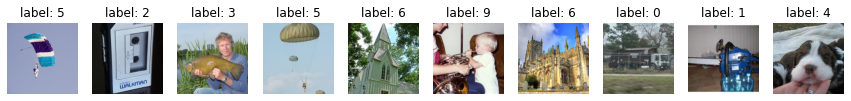

In [10]:
trans = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor(),
])

a = ImagenetteDataset(transform=trans)

show_examples(a, 10)

## Задание 2
**(0.1 балла)** Перенесите свой класс `Trainer` и создайте его инстанс.

*Hints:*

1. Можете взять любую архитектуру сети из предыдущей домашки/семинара или из `torchvision.models`: 
[link](https://pytorch.org/vision/stable/models.html#classification)

In [29]:
writer = SummaryWriter("./check-this/")

fake_loss = 1 / np.arange(1, 100)
for global_step, point in enumerate(fake_loss):
    writer.add_scalar("lossy", point, global_step=global_step)
writer.close()

class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/',
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.val_losses = []
        self.train_losses = []


        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                self.train_losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.post_train_batch()
                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                self.val_losses.append(loss.item())

            val_loss = np.mean(self.val_losses)
            model.post_val_stage(val_loss)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 50,
                smooth_beta: float = 0.8,
                return_ = True) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)


        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()
        
        plt.figure(figsize=(16, 8))
        plt.plot(logs['lr'], logs['loss'])
        plt.xscale('log')
        plt.grid()
        plt.title('LR Range Test')
        plt.show()

        if return_:
            return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

    def plot(self): # добавил для себя, для удобной визуализации
      plt.figure(figsize=(16, 10))
      plt.subplot(2,1,1)
      plt.plot(self.val_losses, label='val sample', color='red')
      plt.ylabel('Loss')
      plt.legend()
      plt.subplot(2,1,2)
      plt.plot(self.train_losses, label='train sample', color='blue')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()   

In [30]:
class VeryModel(nn.Module):
    def __init__(self, inner, lr_scheduler=None, lr_scheduler_type=None):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")
        
        self.inner = inner
        self.fc = nn.Linear(1000, 10)


    def forward(self, x):
        classes = self.inner(x)
        classes = self.fc(classes)

        return classes
        
    
    def compute_all(self, batch):
        x = batch['sample']
        y = batch['label']
        logits = self.forward(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

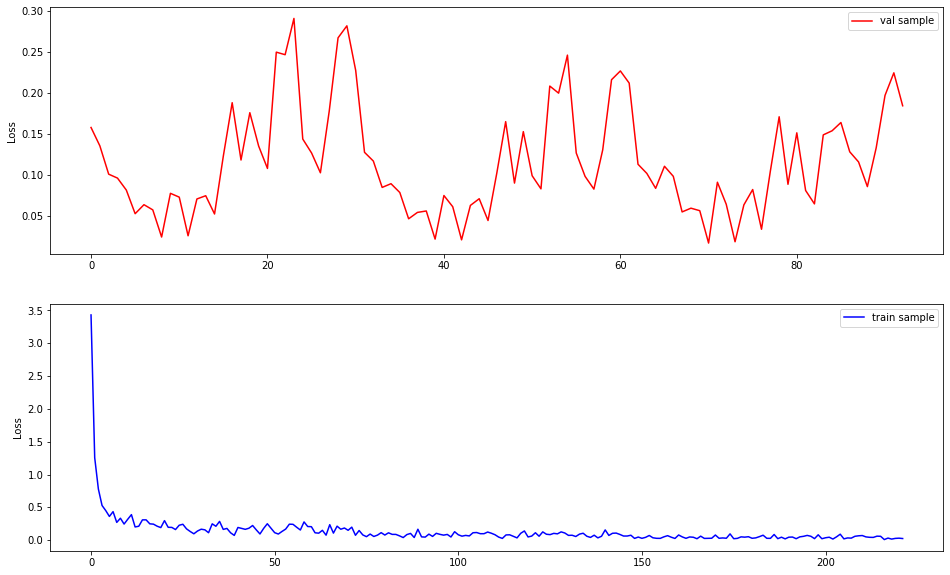

In [50]:
trainset=ImagenetteDataset(is_valid=False, transform=transform)
valset=ImagenetteDataset(is_valid=True, transform=transform)

model = VeryModel(inner = models.resnet18(pretrained=True))
opt = optim.SGD(model.parameters(), lr=1e-2)


trainer = Trainer(model, opt, trainset, valset, batch_size=128, tboard_log_dir='base')
trainer.train(3)

trainer.plot()

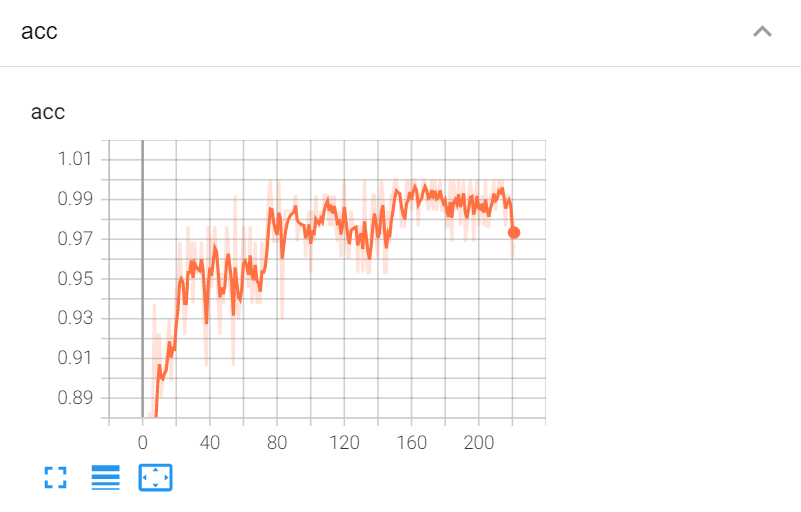

## Задание 3
**(0.1 балла)** Проведите LR Range Test и выберите LR в оптимальных границах.

*Requirement:* график в осях LR - loss должен быть в аутпуте ячейки.

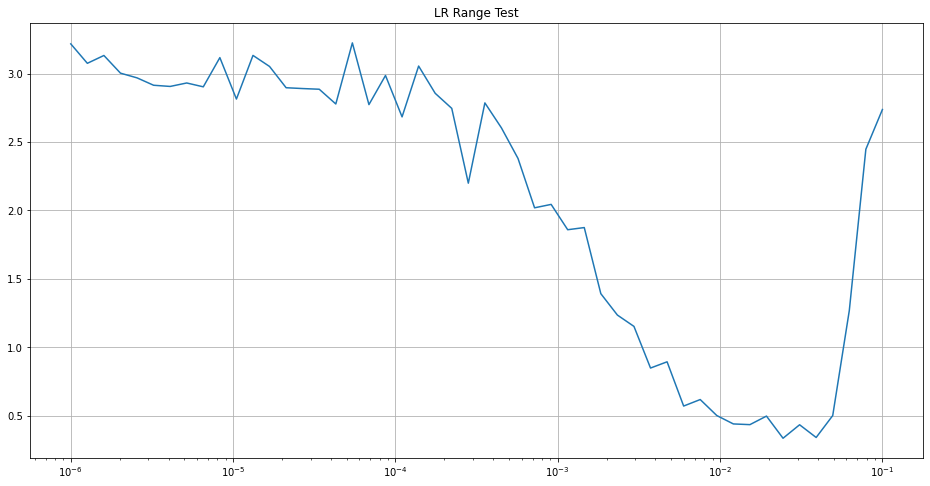

In [41]:
model = VeryModel(inner = models.resnet18(pretrained=True))

opt = optim.SGD(model.parameters(), lr=1e-2)
trainer = Trainer(model, opt, trainset, valset, batch_size=128)
trainer.find_lr(return_=False)

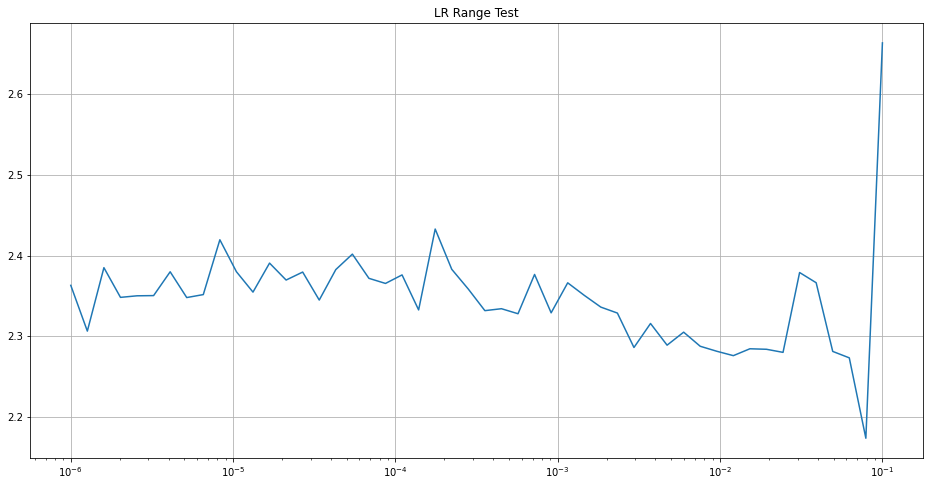

In [48]:
model = VeryModel(inner = models.resnet18(pretrained=False))

opt = optim.SGD(model.parameters(), lr=1e-2)
trainer = Trainer(model, opt, trainset, valset, batch_size=128)
trainer.find_lr(return_=False)

## Задание 4
**(0.2 балла)** Обучите сеть с выбранным LR. Остальные гиперпараметры выберите по своему усмотрению.

*Requirements:*
1. Логи экспериментов должен быть в отдельных папках, чтобы их можно было сравнить в тензорборде
(см. аргумент `log_dir` в [docs](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter)).
1. Метрика `Accuracy`.
1. На этапе валидации метрика должна считаться по всем валидационным объектам, а не отдельно по каждому батчу. 
В тензорборде после валидации должна появиться одна точка.

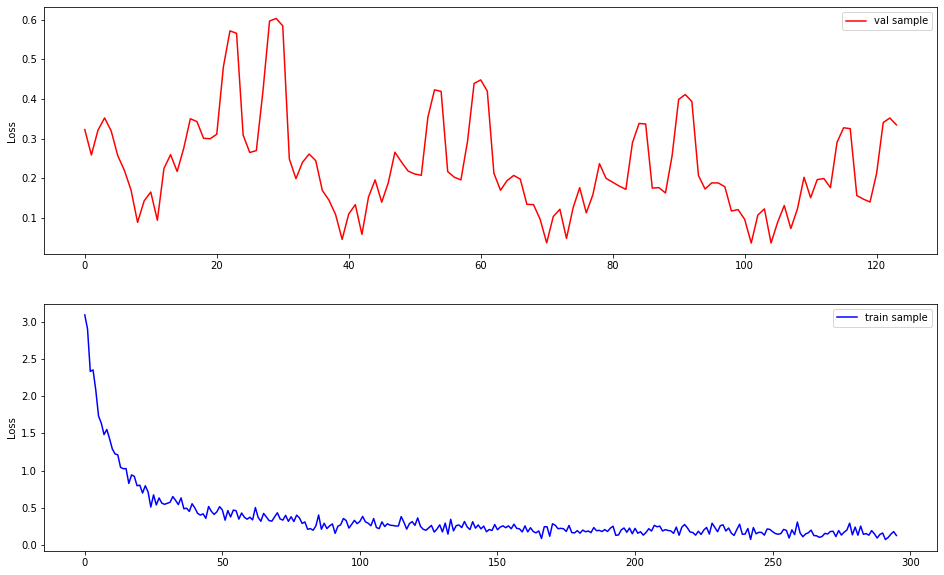

In [49]:
# давайте обучим претрейновый резнет с SGD с lr 1e-3
model = VeryModel(inner = models.resnet18(pretrained=True))
opt = optim.SGD(model.parameters(), lr=1e-3)


trainer = Trainer(model, opt, trainset, valset, batch_size=128, tboard_log_dir='SGD_best_lr')
trainer.train(4)

trainer.plot()

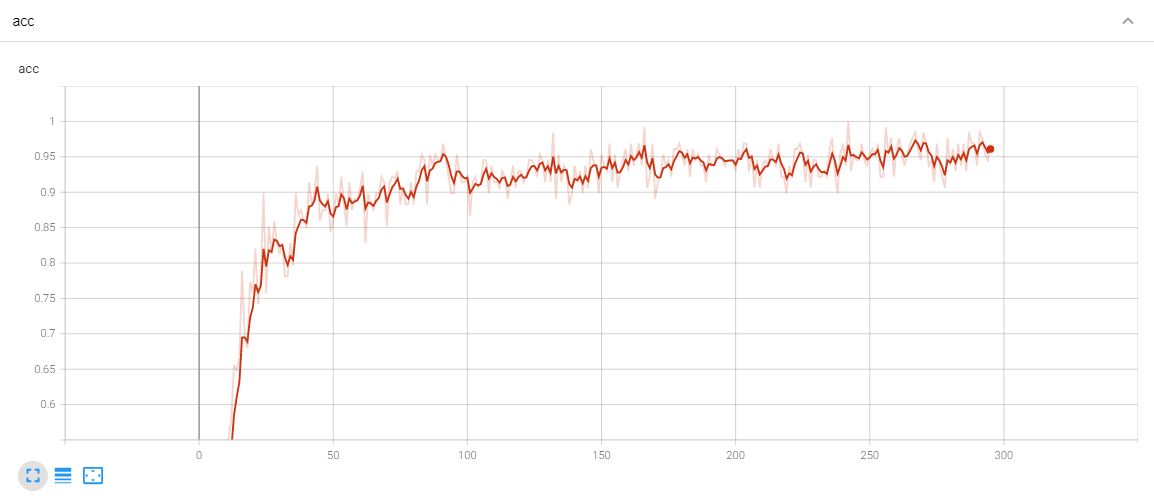

## Задание 5
**(0.4+ балла)** Попробуйте различные гиперпараметры при обучении. Что дает набольший эффект?  
За каждый эксперимент с гиперпараметром из списка дается 0.1 балл:

1. Optimizer: adam, sgd, etc.
1. Batch size.
1. LR scheduler.
1. Freeze weights. Если вы используете предобученную сеть, то попробуйте заморозить тушку (body) и обучать только голову.
1. Weight initialization: zeros, ones, normal, uniform, etc.

*Requirement:* сделайте скриншот тензорборда (несколько, если считаете нужным) с кривыми обучения
(лоссы/метрики на трейне/валидации) проведенных экспериментов и приложите вместе с готовым ноутбуком в anytask.
Из скриншота должно быть понятно в чем заключался эксперимент и как проходило обучение.

*Hint 1:* не меняйте несколько гиперпараметров в одном эксперименте - так непонятно какой из них сыграл.  
*Hint 2:* для заморозки весов, нужно пробежать по параметрам и поставить флаг `param.requires_grad = False` 
(см. [PyTorch discuss](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2)).  
*Hint 3:* для инициализации придется итерироваться по параметрам. 
Менять их значения можно с помощью уже готовых функций: [PyTorch docs](https://pytorch.org/docs/stable/nn.init.html?highlight=init).

In [ ]:
# Попробуем поиграться с оптимайзером
model = VeryModel(inner = models.resnet18(pretrained=True))


list_opt_names = ['SGD', "Adam", "RSMprop"]
list_opt = [optim.SGD(model.parameters(), lr=1e-3),
            optim.Adam(model.parameters(), lr=1e-3),
            optim.RMSprop(model.parameters(), lr=1e-3)]

for opt, dir_name in zip(list_opt, list_opt_names):
    trainer = Trainer(model, opt, trainset, valset, batch_size=128, tboard_log_dir=dir_name)
    trainer.train(3)

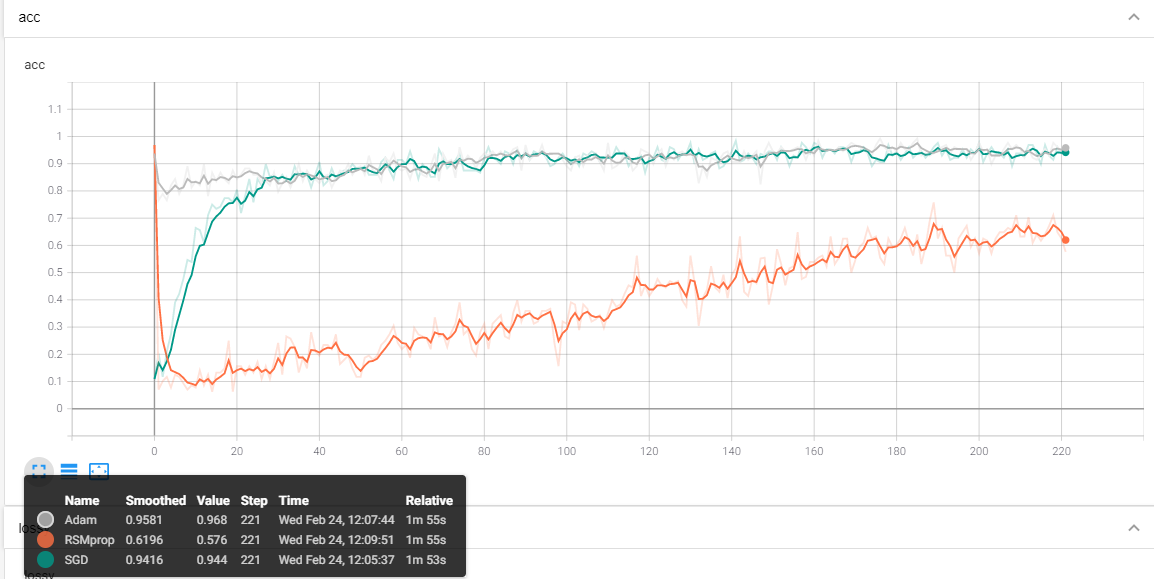

Что-то я не понял прикол, почему RMSprop и Adam исходят первончально из таких высоких точек... Ну ладно

In [ ]:
# Давайте теперь играться с батч сайзом. Будем работать с SGD, т.к. он лучше остальных показал себя в предыдущем эксперементе
batch_list = [32, 64, 128, 256]
opt = optim.SGD(model.parameters(), lr=1e-3)

for bs in batch_list:
    trainer = Trainer(model, opt, trainset, valset, batch_size=bs, tboard_log_dir='SGD_'+str(bs))
    trainer.train(3)

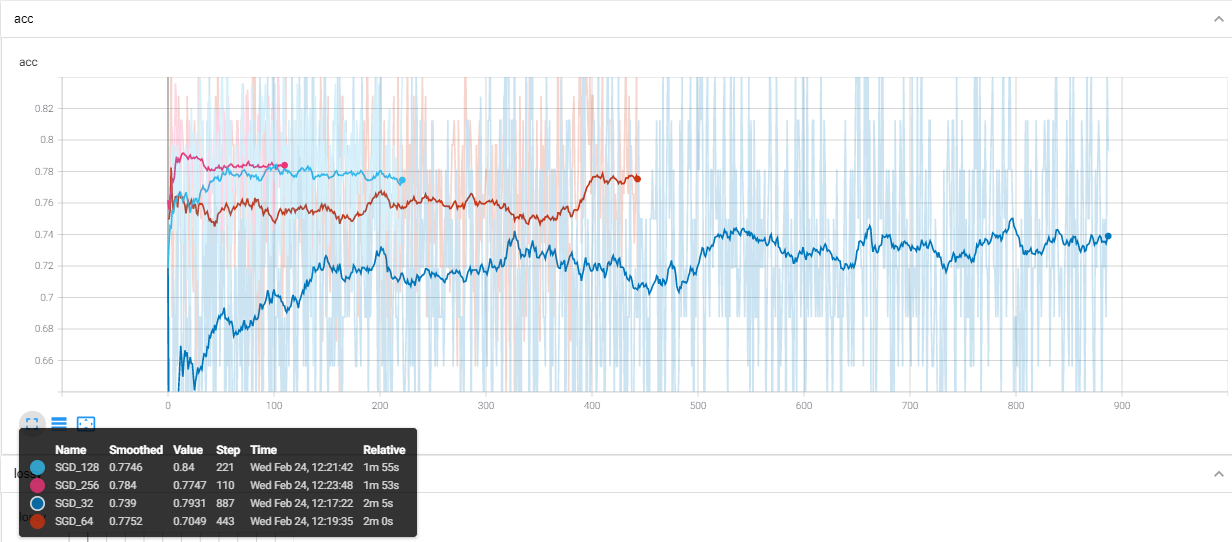

Ну тут не совсем понятно, какой батч сайз, вообще нравится 256, давайте дальше работать с ним

In [61]:
# Давайте эксперементировать с весами при инициализации. Для этого нужно переписать наш VeryModel  
class VeryModel(nn.Module):
    def __init__(self, inner, lr_scheduler=None, lr_scheduler_type=None, init=torch.nn.init.zeros_):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")
        
        self.inner = inner
        self.fc = nn.Linear(1000, 10)
        init(self.fc.weight)

    def forward(self, x):
        classes = self.inner(x)
        classes = self.fc(classes)

        return classes
        
    
    def compute_all(self, batch):
        x = batch['sample']
        y = batch['label']
        logits = self.forward(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

In [ ]:
# Теперь пробуем разные веса
init_weights_list = [torch.nn.init.ones_,
                     torch.nn.init.zeros_,
                     torch.nn.init.normal_,
                     torch.nn.init.uniform_]

for init in init_weights_list:
    model = VeryModel(inner = models.resnet18(pretrained=True), init=init)
    trainer = Trainer(model, opt, trainset, valset, batch_size=256, tboard_log_dir='SGD256+'+str(init).split(' ')[1])
    trainer.train(3)

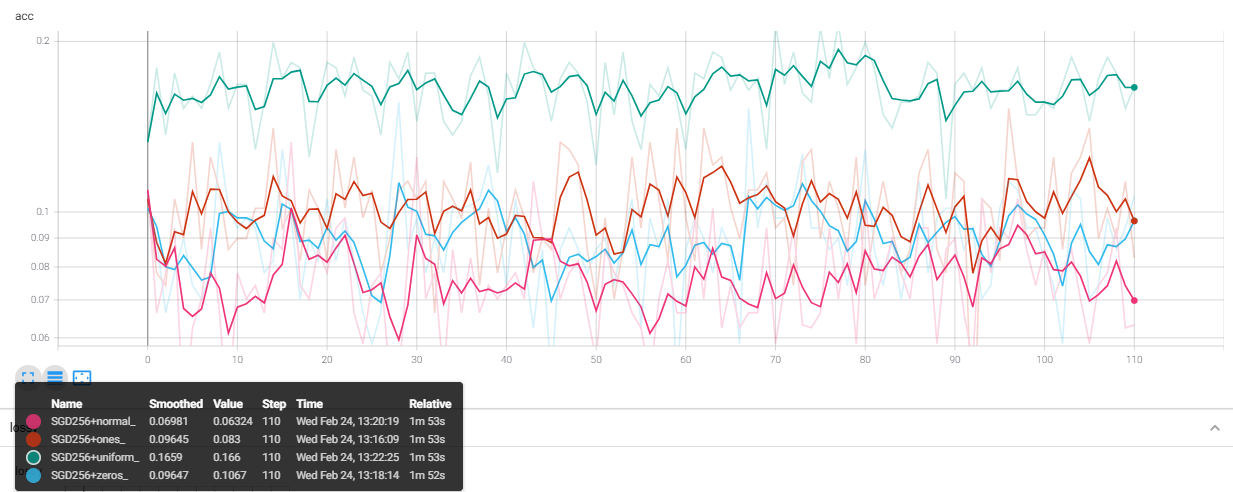

Кажется, я сделал что-то не то, потому что аккьюраси как-то слишком поменялась... Давайте лучше от греха подальше я верну мой VeryModel. Ладно, я пытался! 

In [75]:
class VeryModel(nn.Module):
    def __init__(self, inner, lr_scheduler=None, lr_scheduler_type=None):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")
        
        self.inner = inner
        self.fc = nn.Linear(1000, 10)


    def forward(self, x):
        classes = self.inner(x)
        classes = self.fc(classes)

        return classes
        
    
    def compute_all(self, batch):
        x = batch['sample']
        y = batch['label']
        logits = self.forward(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

In [ ]:
# Давайте теперь займемся заморозкой весов
# Причем сравним, как себя ведет пока что лучшая модель с заморозкой и без

model = VeryModel(inner = models.resnet18(pretrained=True))

i=0
for param in model.parameters():
    i += 1
    if i > 18:
      break
    param.requires_grad = False
trainer = Trainer(model, opt, trainset, valset, batch_size=256, tboard_log_dir='SGD256_freeeze')
trainer.train(3)

In [ ]:
%tensorboard --logdir .

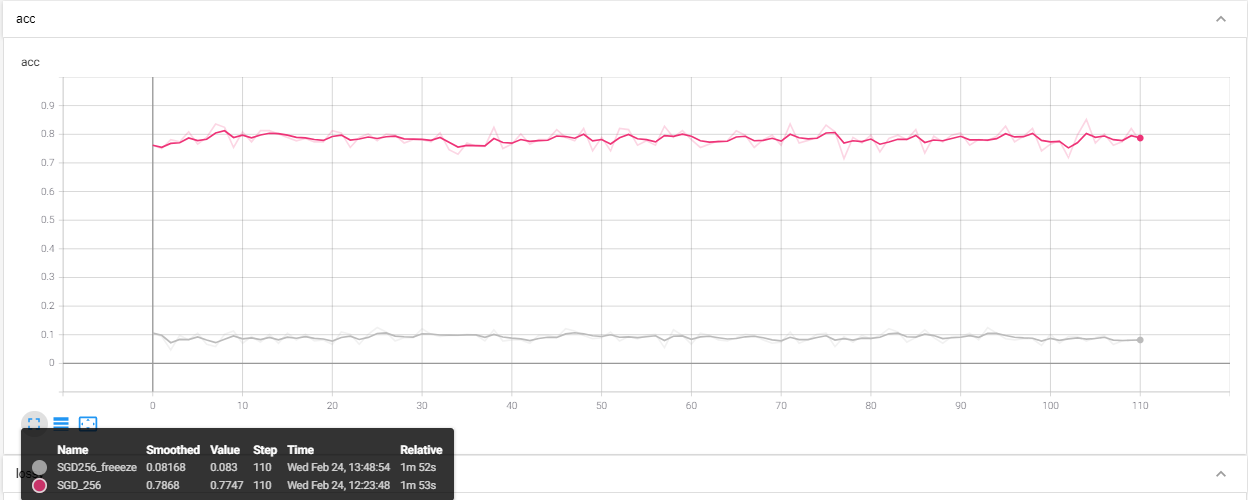

Кажется я все сломал..

## Задание 6 (бонус)
**(0.2 балла, бонус)** Покажите на каких классах лучшая сеть ошибается сильнее всего.

*Requirement:* выведите матрицу ошибок в виде heatmap.

In [51]:
# идея такая: просто сделать два столбца: actual и prediction, чтобы потом посчитать доли различных пар и нарисовать хитмэп. 

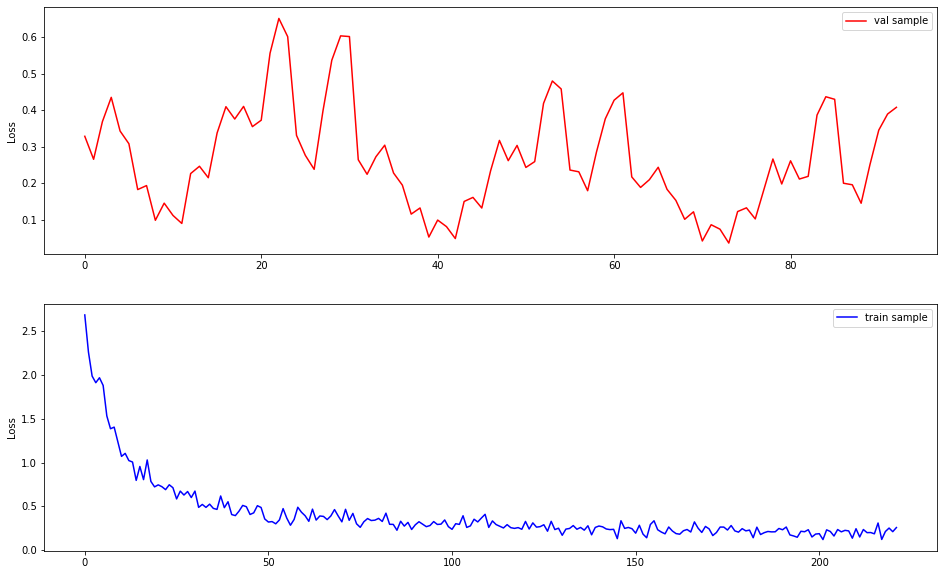

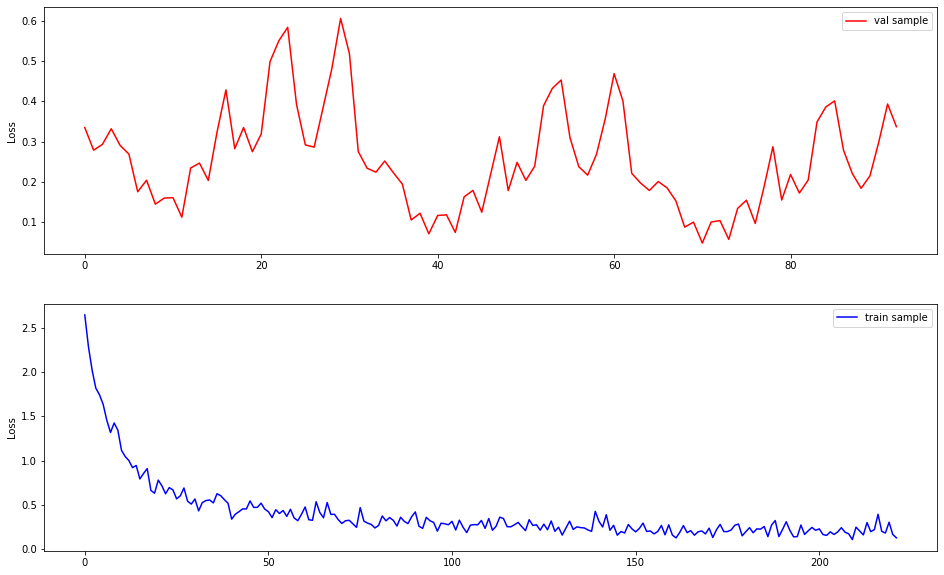

In [156]:
model = VeryModel(inner = models.resnet18(pretrained=True))
opt = optim.SGD(model.parameters(), lr=1e-3)


trainer = Trainer(model, opt, trainset, valset, batch_size=128, tboard_log_dir='for_heatmap')
trainer.train(3)

trainer.plot()

In [157]:
loader = DataLoader(valset, shuffle=False, batch_size=256)
actual = np.array([])
prediction = np.array([])
for batch in loader:
  batch = {k: v.to(0) for k, v in batch.items()}
  res = model.forward(batch['sample']).argmax(axis=1)
  actual = np.concatenate((actual, batch['label'].cpu().numpy()))
  prediction = np.concatenate((prediction, res.cpu().numpy()))

In [158]:
df = pd.DataFrame()
df['actual'] = actual
df['prediction'] = prediction

In [159]:
df

,actual,prediction
0,2.0,2.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0
4,2.0,2.0
...,...,...
3920,8.0,8.0
3921,8.0,8.0
3922,8.0,0.0
3923,8.0,8.0


In [160]:
df['acc'] = (df['actual'] == df['prediction']).astype('int')

In [161]:
df.dropna(inplace=True)

In [162]:
def plot_pivot_table(pivot_table):
    plt.figure(figsize=(15, 15))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, 
                fmt='.3g', annot_kws={"size": 14, "fontsize": 14})
    plt.xticks(fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.xlabel('Actual', size=18)
    plt.ylabel('Prediction', fontsize=18)
    plt.title('Результат работы нейронной сети', fontsize=20)
    plt.show()

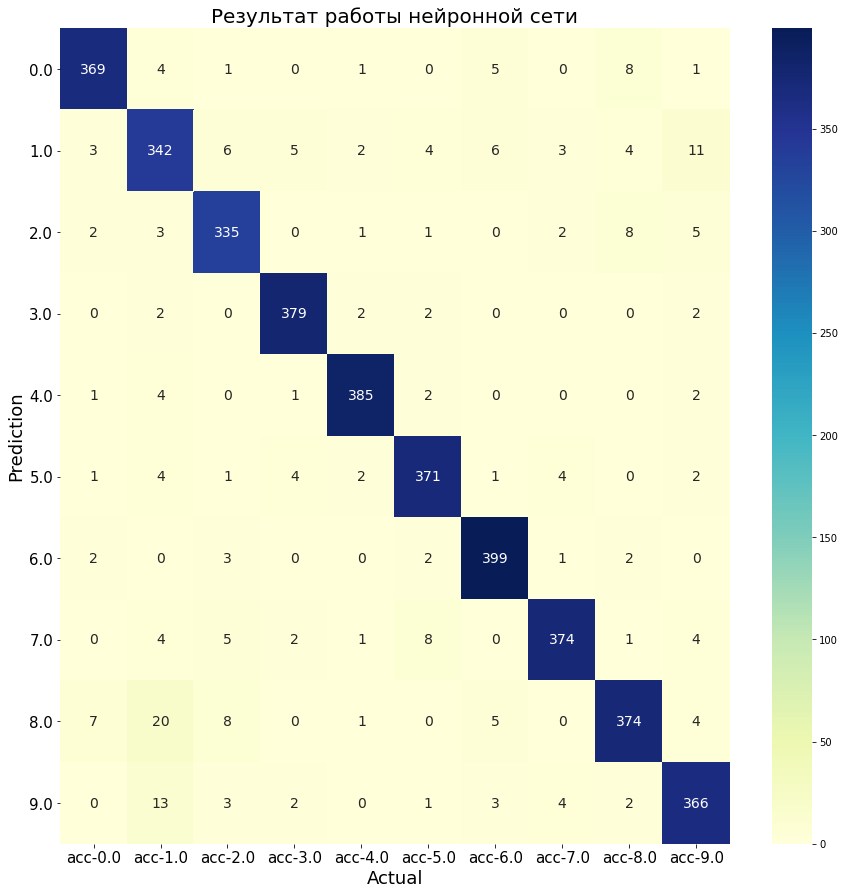

In [163]:
plot_pivot_table(pd.pivot_table(df, index='actual', columns=df.prediction, aggfunc='count', fill_value=0))

Чаще всего ошибаемся на 2, 3 и 9 классах